In [3]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)

In [4]:
from pymongo import MongoClient
client = MongoClient()
client = MongoClient('localhost', 27017)

In [5]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
dictlis = [{'element':'Cu', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Cu', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ag', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ag', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pt', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pt', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
#            {'element':'NiGa', 'mirror':'110', 'moved+':'no', 'moved':'no'},
#            {'element':'CoPt3', 'mirror':'100', 'moved+':'no', 'moved':'no'},
           {'element':'Pd', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Pd', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Au', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Au', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Al', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Al', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Ni', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Ni', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},           
          ]

In [5]:
results = []
for dic in dictlis:
    tmp = []
    for post in collection.find(dic):
        tmp.append(post)
    results.append(tmp)

df = []
dfpred = []

for i in range(len(results)):
    df.append(pd.DataFrame(results[i]))
    dfpred.append(df[i][df[i]['numberofads'] > 1])

for i in range(len(dfpred)):
    dfpred[i] = dfpred[i].reset_index()

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]
    
### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsEne/suratom'] >= -2.0]

In [7]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
covset

[[0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0]]

### Predict ####

In [8]:
def predE(df, COinteractionflag ,CObondlengthflag):
    name = df['name']
    res = re.match('(.*u\d).*', name)
    barefile = res.group(1) + '.traj'
    bareatoms = query(barefile, 'spacom')
    slabE = bareatoms.get_potential_energy()
    
    igroups = df['igroups']
    adsElis = [] # adsE + slabE
    COEdifflis = []
    a2 = 46.252
    a1 = -106.43
    a0 = 46.754
    def COene(COlen):
        return a2*COlen**2 + a1*COlen + a0
    
    for i in range(len(igroups)):
        tmp = []
        tmp.append(igroups[i])
        se = {'element':df['element'], 'mirror':df['mirror'], 'unitlength':int(df['unitlength']), 'igroups':tmp}
        adsE = collection.find_one(se)['totaladsEnergy']
        adsElis.append(adsE)
        COlen = collection.find_one(se)['COlengthlis'][0]
        COEdiff = COene(COlen) - COene(1.148)
        COEdifflis.append(COEdiff)
    
    Eint = df['ECO_Eint'] - COene(1.148)*df['numberofads']
    preadsdene = sum(adsElis)
    if COinteractionflag:
        preadsdene += Eint
    if CObondlengthflag:
        preadsdene += sum(COEdifflis)
    predadsene_surf = preadsdene/df['surfatomnum']
    
    return predadsene_surf, adsElis, Eint

AttributeError: 'str' object has no attribute 'get_potential_energy'

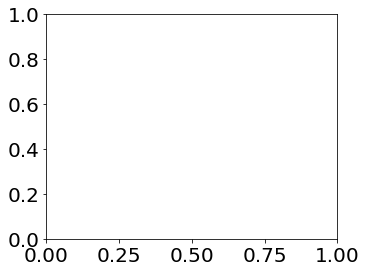

In [9]:
xrange = np.linspace(-2, 2)

fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100
    dfpred[i]['predE/surfatom'] = 0
    dfpred[i]['sumadsE/surfatom'] = 0
    dfpred[i]['Eint/surfatom'] = 0
    for j in range(len(dfpred[i])):
        dfpred[i].iloc[j, -3] = predE(dfpred[i].iloc[j], True, False)[0]
        dfpred[i].iloc[j, -2] = sum(predE(dfpred[i].iloc[j], True, False)[1])/dfpred[i].iloc[j]['surfatomnum']
        dfpred[i].iloc[j, -1] = predE(dfpred[i].iloc[j], True, False)[2]/dfpred[i].iloc[j]['surfatomnum']
    for j in range(len(covset[i])):
        predElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['predE/surfatom'])
        calcElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['aveadsEne/suratom'])
        if calcElis == []:
            continue
        if xmin > np.min(calcElis):
            xmin = np.min(calcElis)
        if xmax < np.max(calcElis):
            xmax = np.max(calcElis)
        ax.plot(calcElis, predElis, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('VASP')
    ax.set_ylabel('predicted')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
plt.show()

In [10]:
for i in range(len(dfpred)):
    dfpred[i]['VASP - prediction'] = dfpred[i]['aveadsEne/suratom'] - dfpred[i]['predE/surfatom']    

In [11]:
# 0 :Cu 100
# 1 :Cu 111
# 2 :Ag 100
# 3 :Ag 111
# 4 :Pt 100
# 5 :Pt 111
# 6 :Pd 100
# 7 :Pd 111
# 8 :Au 100
# 9 :Au 111
# 10:Al 100
# 11:Al 111
# 12:Ni 100           
# 13:Ni 111

In [12]:
ele_mir = 7

dfpred_disp = dfpred[ele_mir][['name','element','mirror','coverage','aveadsEne/suratom','predE/surfatom',\
                               'sumadsE/surfatom','Eint/surfatom','VASP - prediction']]

# pd.options.display.precision = 3
dfpred_disp.sort_values(by=['coverage']).round(3)

,name,element,mirror,coverage,aveadsEne/suratom,predE/surfatom,sumadsE/surfatom,Eint/surfatom,VASP - prediction
0,Pd_111_u2_no002_CO_n2_d3.traj,Pd,111,0.50,-0.384,-0.444,-0.542,0.098,0.059
3,Pd_111_u2_no005_CO_n2_d4.traj,Pd,111,0.50,-0.593,0.406,0.375,0.031,-0.999
5,Pd_111_u2_no007_CO_n2_d4.traj,Pd,111,0.50,-0.615,-0.637,-0.668,0.031,0.022
7,Pd_111_u2_no012_CO_n2_d3.traj,Pd,111,0.50,-0.533,-0.627,-0.725,0.098,0.094
8,Pd_111_u2_no016_CO_n2_d3.traj,Pd,111,0.50,-0.619,-0.696,-0.795,0.099,0.077
11,Pd_111_u2_no019_CO_n2_d4.traj,Pd,111,0.50,-0.667,0.280,0.249,0.031,-0.947
12,Pd_111_u2_no021_CO_n2_d3.traj,Pd,111,0.50,-0.605,1.390,1.292,0.099,-1.995
1,Pd_111_u2_no003_CO_n3_d3.traj,Pd,111,0.75,-0.366,-0.509,-0.813,0.305,0.142
4,Pd_111_u2_no006_CO_n3_d4.traj,Pd,111,0.75,-0.804,0.096,-0.023,0.118,-0.899
9,Pd_111_u2_no017_CO_n3_d3.traj,Pd,111,0.75,-0.669,-0.887,-1.192,0.305,0.218


In [13]:
id = 1
env = 'local'

name = dfpred[ele_mir].iloc[id]['name']
allname = dfpred[ele_mir].iloc[id]['name'][:-5] + '_all.traj'
# query(name, env)
# query(allname, env)

In [14]:
for i in range(len(dfpred)):
    dfpred[i]['#nbads'] = 0 # nearest bonding distance
    dfpred[i]['nbdist'] = 0 # nearest bonding distance    
    for j in range(len(dfpred[i])):
        name = dfpred[i].iloc[j]['name']
        atoms = query(name)
        repeat = 3 # repeat
        ratoms = get_repeated_atoms(atoms, repeat)

        b_mat, nads = get_bonding_matrix(ratoms)
        results = get_number_matrix(b_mat, nads, repeat)
        try:
            nbdist = np.min(results[:,1])
            nnbads = 0
            for item in results:
                if item[1] == nbdist:
                    nnbads += item[2]
            print(name, nbdist, nnbads)
            dfpred[i].iloc[j, -2] = nnbads
            dfpred[i].iloc[j, -1] = nbdist
        except:
            print('Error')

Cu_100_u2_no02_CO_n2_d3.traj 3 4
Cu_100_u2_no03_CO_n3_d3.traj 3 8
Cu_100_u2_no04_CO_n4_d3.traj 3 16
Cu_100_u2_no05_CO_n3_d3.traj 3 14
Cu_100_u2_no06_CO_n4_d3.traj 2 4
Cu_100_u2_no07_CO_n2_d5.traj 4 32
Cu_100_u2_no08_CO_n2_d3.traj 3 6
Cu_100_u2_no09_CO_n3_d3.traj 2 4
Cu_100_u2_no11_CO_n2_d3.traj 3 12
Cu_100_u2_no12_CO_n3_d3.traj 2 4
Cu_100_u2_no13_CO_n4_d3.traj 2 8
Cu_100_u2_no14_CO_n3_d3.traj 2 8
Cu_100_u2_no15_CO_n4_d3.traj 2 24
Cu_100_u2_no16_CO_n2_d5.traj 3 12
Cu_100_u2_no18_CO_n3_d3.traj 2 16
Cu_100_u2_no19_CO_n2_d3.traj 2 4
Cu_100_u2_no21_CO_n2_d3.traj 2 8
Cu_100_u2_no22_CO_n3_d3.traj 2 24
Cu_100_u2_no23_CO_n4_d3.traj 2 48
Cu_100_u2_no24_CO_n2_d5.traj 2 8
Cu_111_u2_no02_CO_n2_d3.traj 3 4
Cu_111_u2_no03_CO_n3_d3.traj 3 12
Cu_111_u2_no04_CO_n4_d3.traj 3 24
Cu_111_u2_no05_CO_n2_d4.traj 3 18
Cu_111_u2_no06_CO_n3_d4.traj 2 6
Cu_111_u2_no07_CO_n2_d4.traj 3 18
Cu_111_u2_no09_CO_n2_d3.traj 3 20
Cu_111_u2_no10_CO_n3_d3.traj 2 4
Cu_111_u2_no11_CO_n4_d3.traj 2 8
Cu_111_u2_no12_CO_n2_d3.traj 

Ni_111_u2_no007_CO_n2_d3.traj 3 18
Ni_111_u2_no009_CO_n2_d3.traj 2 4
Ni_111_u2_no016_CO_n2_d3.traj 2 4
Ni_111_u2_no017_CO_n3_d3.traj 2 12
Ni_111_u2_no018_CO_n4_d3.traj 2 24
Ni_111_u2_no019_CO_n2_d3.traj 2 6
Ni_111_u2_no021_CO_n2_d3.traj 2 4
Ni_111_u2_no022_CO_n3_d3.traj 2 12
Ni_111_u2_no023_CO_n4_d3.traj 2 24


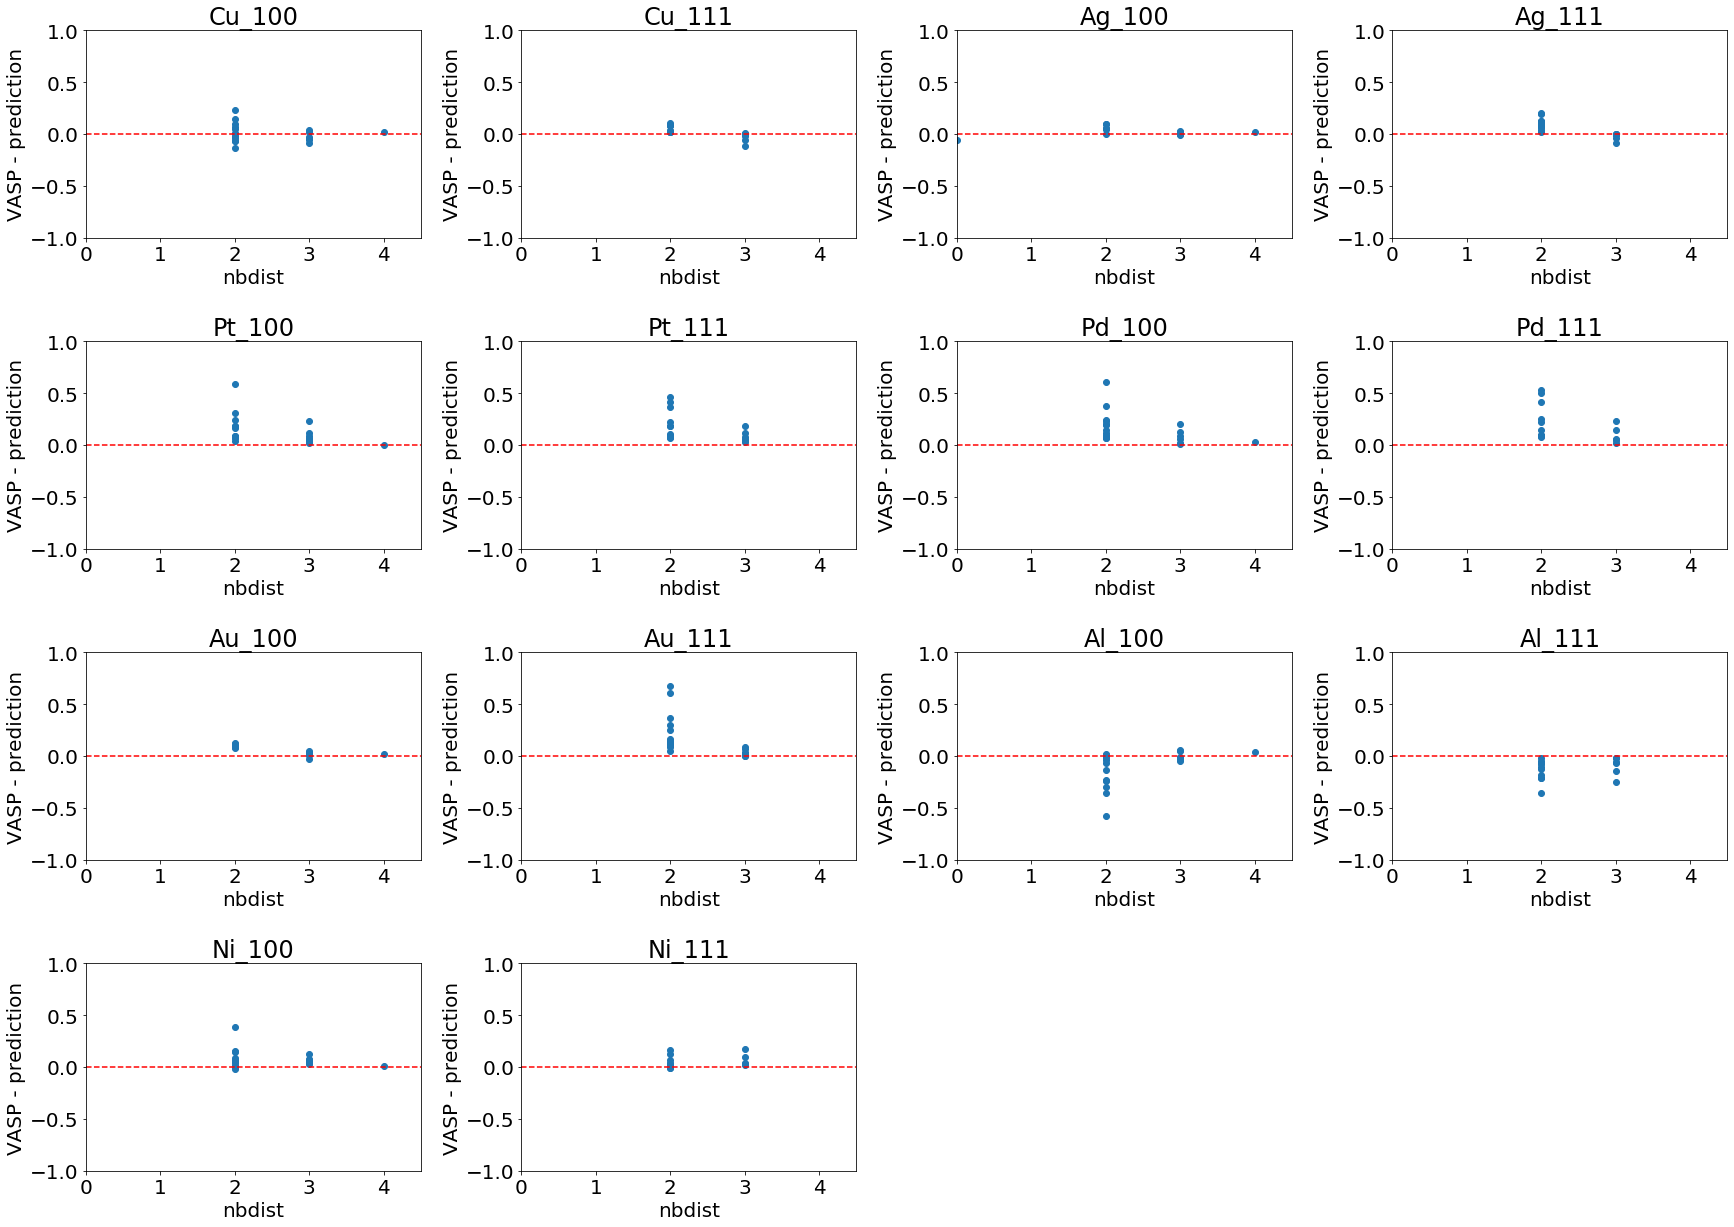

In [15]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 4.5
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i]['nbdist'], dfpred[i]['VASP - prediction'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way

    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('nbdist')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


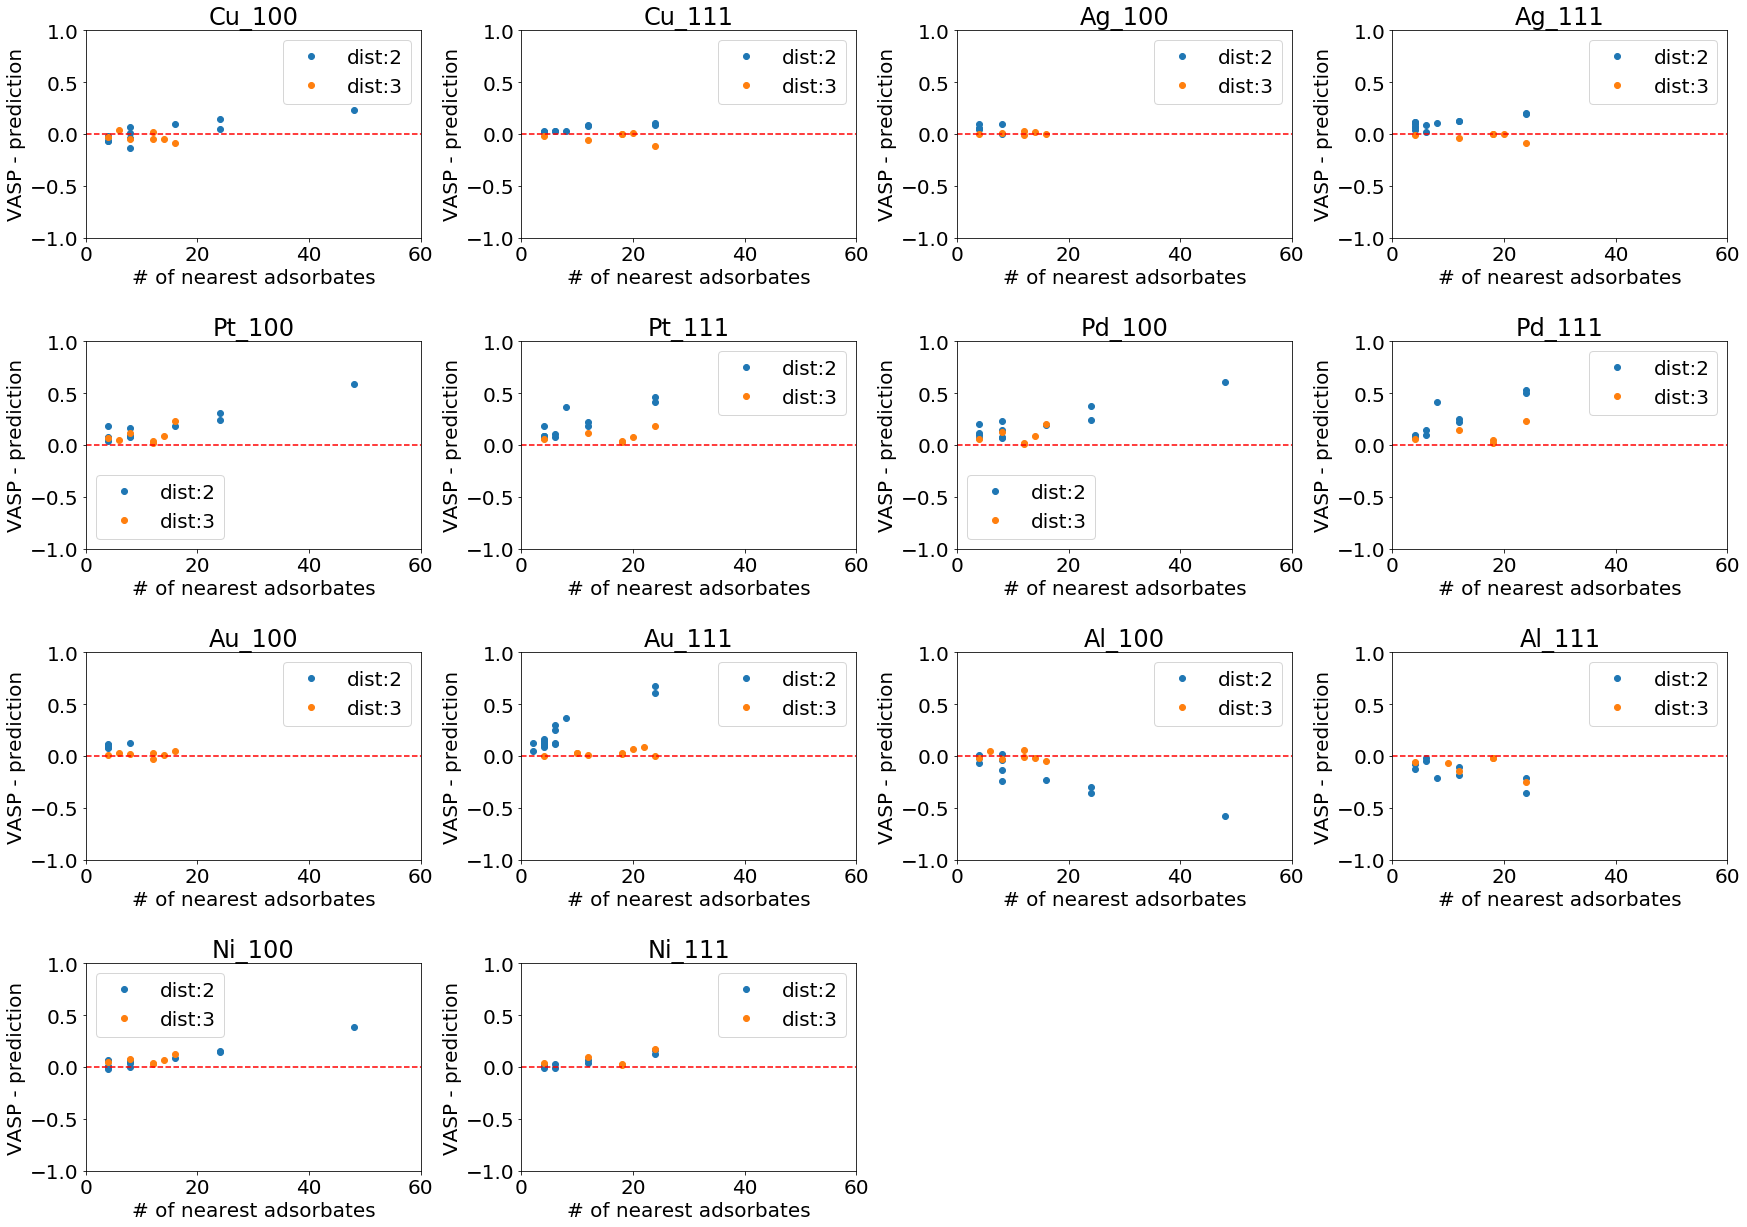

In [16]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 60
# nbdist = 2
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['nbdist']==2]['#nbads'], dfpred[i][dfpred[i]['nbdist']==2]['VASP - prediction'], 'o')
    ax.plot(dfpred[i][dfpred[i]['nbdist']==3]['#nbads'], dfpred[i][dfpred[i]['nbdist']==3]['VASP - prediction'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

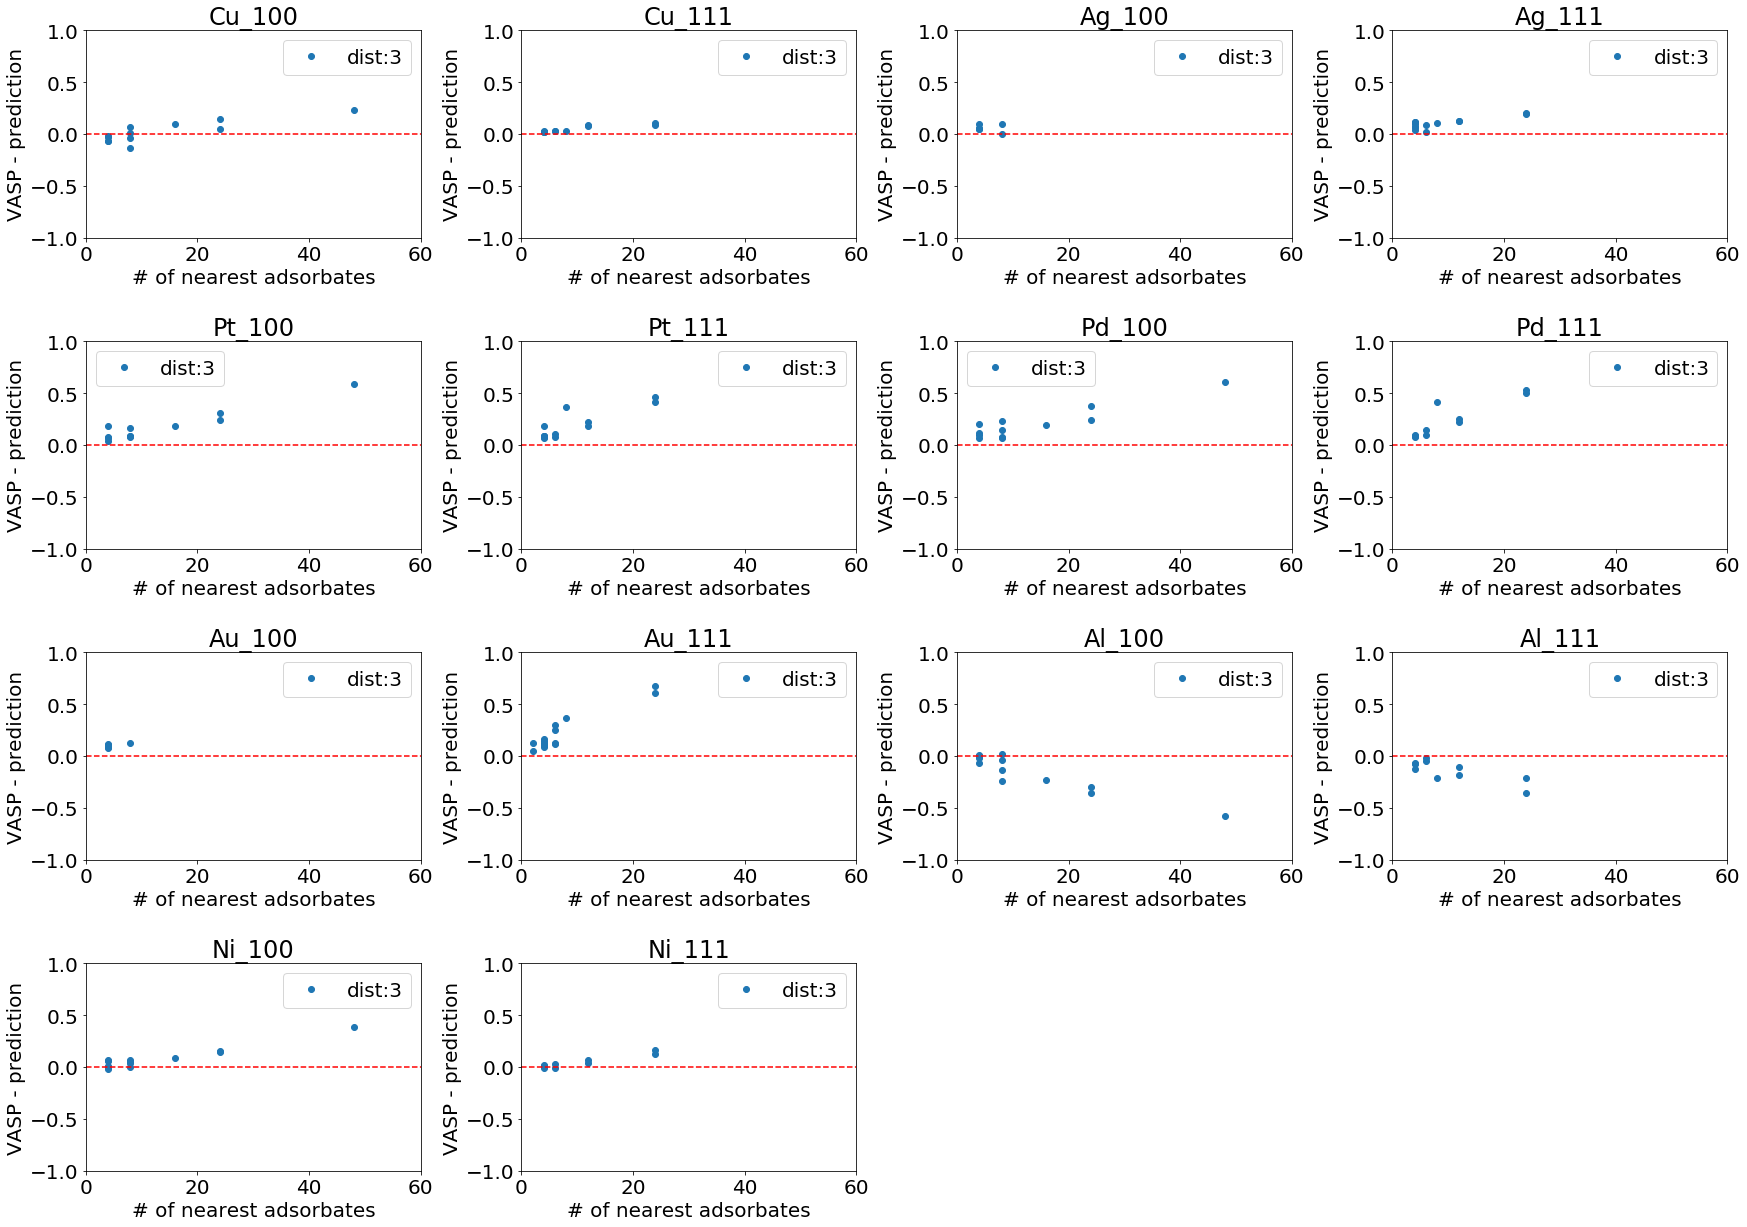

In [19]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 60
# nbdist = 2
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['nbdist']==2]['#nbads'], dfpred[i][dfpred[i]['nbdist']==2]['VASP - prediction'], 'o',color='C0')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

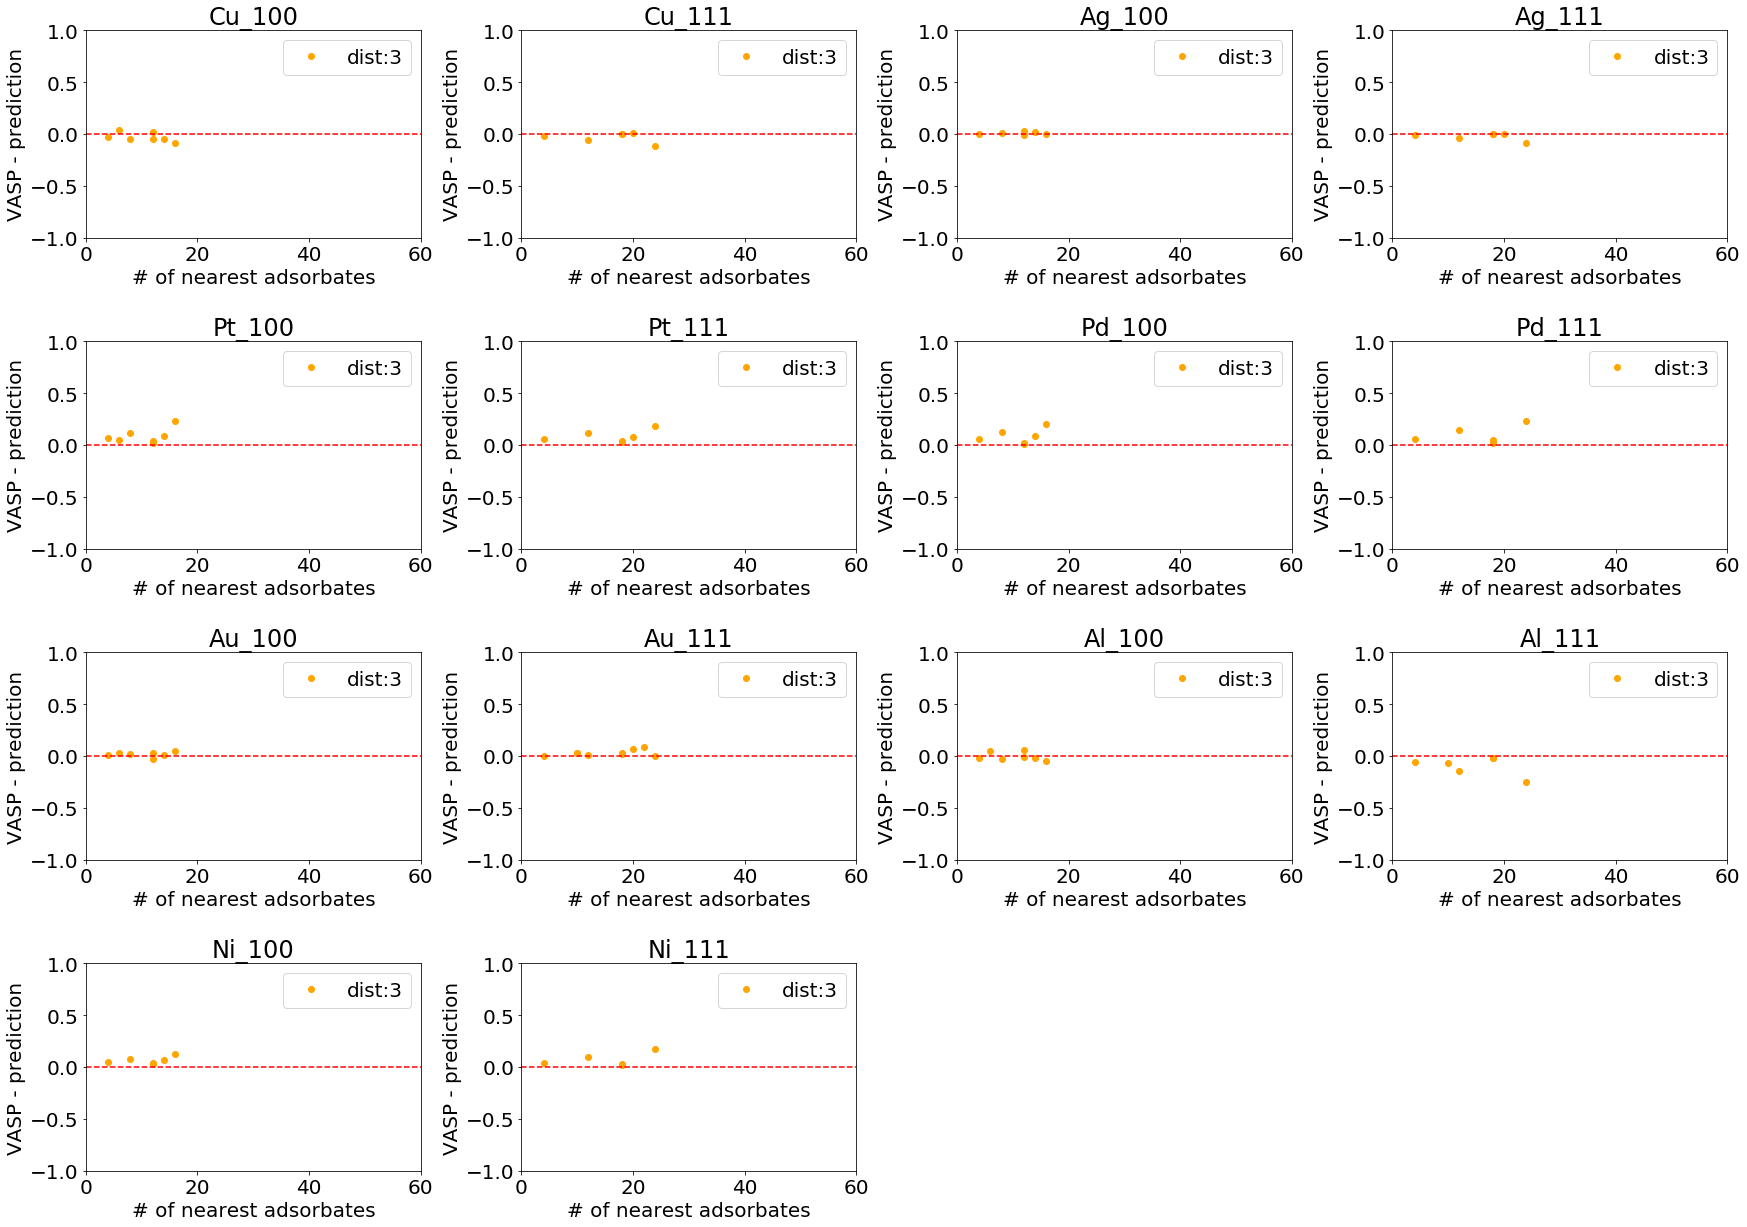

In [20]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 60
# nbdist = 2
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['nbdist']==3]['#nbads'], dfpred[i][dfpred[i]['nbdist']==3]['VASP - prediction'], 'o',color='orange')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

In [21]:
sur_mir = 4
nbdist = 3
dfpred[sur_mir][dfpred[sur_mir]['nbdist']==nbdist]
# dfpred[sur_mir][dfpred[sur_mir]['coverage']==1.0]

,index,_id,name,element,mirror,adsorbate,unitlength,surfatomnum,area,Energy,totaladsEnergy,aveadsEne/suratom,numberofads,coverage,density,igroups,iposlis,rgroups,rposlis,ECO_Eint,Ediff,COlengthlis,aveadsEne/ads,moved+,moved,predE/surfatom,sumadsE/surfatom,Eint/surfatom,VASP - prediction,#nbads,nbdist
2,4,5d7c0ec424fcd5b4cb7e3459,Pt_100_u2_no02_CO_n2_d3.traj,Pt,100,CO,2,4,31.852978,-112.442414,-2.523344,-0.630836,2,0.50,0.062788,"[0, 0]","[[2.8219221178541876, 0.0, 17.836200796545], [...","[0, 0]","[[2.8219397825090318, 1.9537666826458362e-05, ...",-28.559167,-83.883246,"[1.1653659849139961, 1.1652442894838217]",-1.261672,no,no,-0.696347,-0.792527,0.096180,0.065511,4,3
3,5,5d7c0ec524fcd5b4cb7e345b,Pt_100_u2_no03_CO_n3_d3.traj,Pt,100,CO,2,4,31.852978,-127.897171,-3.492664,-0.873166,3,0.75,0.094183,"[0, 0, 0]","[[0.0, 2.8219221178541876, 17.836200796545], [...","[0, 0, 0]","[[2.988227997052703e-06, 2.8219095850052685, 1...",-42.612363,-85.284807,"[1.1641750631911332, 1.1659372308020846, 1.165...",-1.164221,no,no,-0.987923,-1.188790,0.200867,0.114757,8,3
7,9,5d7c0ec824fcd5b4cb7e3461,Pt_100_u2_no04_CO_n4_d3.traj,Pt,100,CO,2,4,31.852978,-142.649801,-3.759858,-0.939965,4,1.00,0.125577,"[0, 0, 0, 0]","[[2.8219221178541876, 2.8219221178541876, 17.8...","[0, 0, 0, 0]","[[2.8220108954112044, 2.8218315241108343, 17.9...",-56.220506,-86.429295,"[1.1645187092428217, 1.1647531206758004, 1.164...",-0.939965,no,no,-1.168236,-1.585054,0.416818,0.228272,16,3
8,10,5d7c0ec924fcd5b4cb7e3462,Pt_100_u2_no05_CO_n3_d3.traj,Pt,100,CO,2,4,31.852978,-128.229449,-3.824942,-0.956236,3,0.75,0.094183,"[1, 0, 0]","[[1.410961058927089, 2.8219221178541853, 17.83...","[1, 0, 0]","[[1.4109607845325145, 2.8219223238309716, 17.4...",-42.751981,-85.477467,"[1.1618308849648593, 1.1618401181771616, 1.192...",-1.274981,no,no,-1.045593,-1.211556,0.165963,0.089358,14,3
11,13,5d7c0ecb24fcd5b4cb7e3465,Pt_100_u2_no08_CO_n2_d4.traj,Pt,100,CO,2,4,31.852978,-113.017243,-3.098173,-0.774543,2,0.50,0.062788,"[1, 0]","[[2.8219221178541876, 4.232883176781282, 17.83...","[1, 0]","[[2.8219221580306337, 4.111806790143082, 17.47...",-28.976393,-84.040850,"[1.1625080070419385, 1.189820918825792]",-1.549087,no,no,-0.823419,-0.815293,-0.008126,0.048875,6,3
13,16,5d7c0ecd24fcd5b4cb7e3468,Pt_100_u2_no11_CO_n2_d3.traj,Pt,100,CO,2,4,31.852978,-112.805000,-2.885930,-0.721482,2,0.50,0.062788,"[1, 1]","[[5.643844235708372, 4.232883176781282, 17.836...","[1, 1]","[[1.7287499020312484e-05, 4.232883755086303, 1...",-28.559167,-84.245832,"[1.1840670494389023, 1.1840646348379404]",-1.442965,no,no,-0.741878,-0.838058,0.096180,0.020396,12,3
20,23,5d7c0ed124fcd5b4cb7e3470,Pt_100_u2_no19_CO_n2_d5.traj,Pt,100,CO,2,4,31.852978,-113.164350,-3.245280,-0.811320,2,0.50,0.062788,"[1, 1]","[[0.0, 1.410961058927093, 17.836200796545], [2...","[1, 1]","[[-2.754981188096626e-05, 1.4109619559517204, ...",-28.978344,-84.186006,"[1.1855197894766332, 1.185734959994549]",-1.622640,no,no,-0.846672,-0.838058,-0.008614,0.035352,12,3


In [22]:
id = 11
name = dfpred[sur_mir][dfpred[sur_mir]['nbdist']==nbdist].loc[id]['name']
query(name,'local')

Atoms(symbols='Pt16COCO', pbc=[True, True, False], cell=[5.643844235708376, 5.643844235708376, 25.986200796545], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7]), calculator=SinglePointCalculator(...))

In [26]:
for i in range(len(dfpred)):
    dfpred[i]['finalF'] = 0
    for j in range(len(dfpred[i])):
        name = dfpred[i].iloc[j]['name']
        dfpred[i].iloc[j, -1] = np.max(np.abs(query(name, 'spacom').get_forces()))

In [85]:
ele_mir = 0
dfpred[ele_mir][dfpred[ele_mir]['finalF'] > 0.03]

,index,_id,name,element,mirror,adsorbate,unitlength,surfatomnum,area,Energy,totaladsEnergy,aveadsEne/suratom,numberofads,coverage,density,igroups,iposlis,rgroups,rposlis,ECO_Eint,Ediff,COlengthlis,aveadsEne/ads,moved+,moved,predE/surfatom,sumadsE/surfatom,Eint/surfatom,VASP - prediction,#nbads,nbdist,finalF
1,3,5d7c0d9a24fcd5b4cb7e33c3,Cu_100_u2_no03_CO_n3_d3.traj,Cu,100,CO,2,4,27.039622,-91.618491,-0.193395,-0.048349,3,0.75,0.110948,"[0, 0, 0]","[[0.0, 2.5999818152500223, 17.365394317575], [...","[0, 0, 0]","[[1.4637024961441158e-05, 2.599985486338773, 1...",-41.783691,-49.834801,"[1.1606830858701331, 1.1599647924450138, 1.159...",-0.064465,no,no,-0.004514,-0.412550,0.408035,-0.043834,8,3,0.107935
4,6,5d7c0d9c24fcd5b4cb7e33c6,Cu_100_u2_no06_CO_n4_d3.traj,Cu,100,CO,2,4,27.039622,-105.510367,0.400166,0.100041,4,1.00,0.147931,"[1, 1, 0, 0]","[[3.8999727228750336, 2.5999818152500223, 17.3...","[1, 1, 0, 0]","[[3.899972264833885, 2.5999823175029344, 17.15...",-55.138664,-50.371702,"[1.1580723784124727, 1.158072372623562, 1.1734...",0.100041,no,no,0.170032,-0.517246,0.687278,-0.069991,4,2,0.097855
5,7,5d7c0d9c24fcd5b4cb7e33c7,Cu_100_u2_no07_CO_n2_d5.traj,Cu,100,CO,2,4,27.039622,-77.961554,-1.021894,-0.255473,2,0.50,0.073966,"[0, 0]","[[2.5999818152500223, 2.5999818152500223, 17.3...","[0, 0]","[[2.599981925251661, 2.5999817550950066, 17.46...",-28.945549,-49.016005,"[1.1604420475275021, 1.1629487064466688]",-0.510947,no,no,-0.275448,-0.275033,-0.000415,0.019975,32,4,0.206950
6,8,5d7c0d9d24fcd5b4cb7e33c8,Cu_100_u2_no08_CO_n2_d3.traj,Cu,100,CO,2,4,27.039622,-77.824966,-0.885306,-0.221327,2,0.50,0.073966,"[1, 0]","[[2.5999818152500223, 1.2999909076250111, 17.3...","[1, 0]","[[2.599976653415929, 1.5818870188997392, 17.12...",-28.945152,-48.879814,"[1.1589229446515121, 1.1778122043530543]",-0.442653,no,no,-0.258939,-0.258623,-0.000316,0.037612,6,3,0.244796
9,12,5d7c0d9f24fcd5b4cb7e33cc,Cu_100_u2_no12_CO_n3_d3.traj,Cu,100,CO,2,4,27.039622,-91.509268,-0.084171,-0.021043,3,0.75,0.110948,"[1, 1, 1]","[[2.5999818152500223, 3.8999727228750336, 17.3...","[1, 1, 1]","[[2.599982941535325, 3.8999768324019777, 17.22...",-41.783691,-49.725577,"[1.1760116326032013, 1.170818030011036, 1.1722...",-0.028057,no,no,0.044716,-0.363319,0.408035,-0.065759,4,2,0.078765
14,17,5d7c0da324fcd5b4cb7e33d2,Cu_100_u2_no18_CO_n3_d3.traj,Cu,100,CO,2,4,27.039622,-90.951851,0.473246,0.118311,3,0.75,0.110948,"[2, 2, 1]","[[3.899972722875034, 3.899972722875034, 17.365...","[2, 2, 1]","[[3.8800134476221513, 3.8997736441153736, 16.8...",-42.043703,-48.908148,"[1.1663025109484761, 1.1937094289652537, 1.193...",0.157749,no,no,0.023137,-0.319896,0.343032,0.095174,16,2,0.102711


In [62]:
from sklearn.linear_model import LinearRegression
Lin = LinearRegression(fit_intercept=False)

def linearfit(X, y):
    Lin.fit(X, y)
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

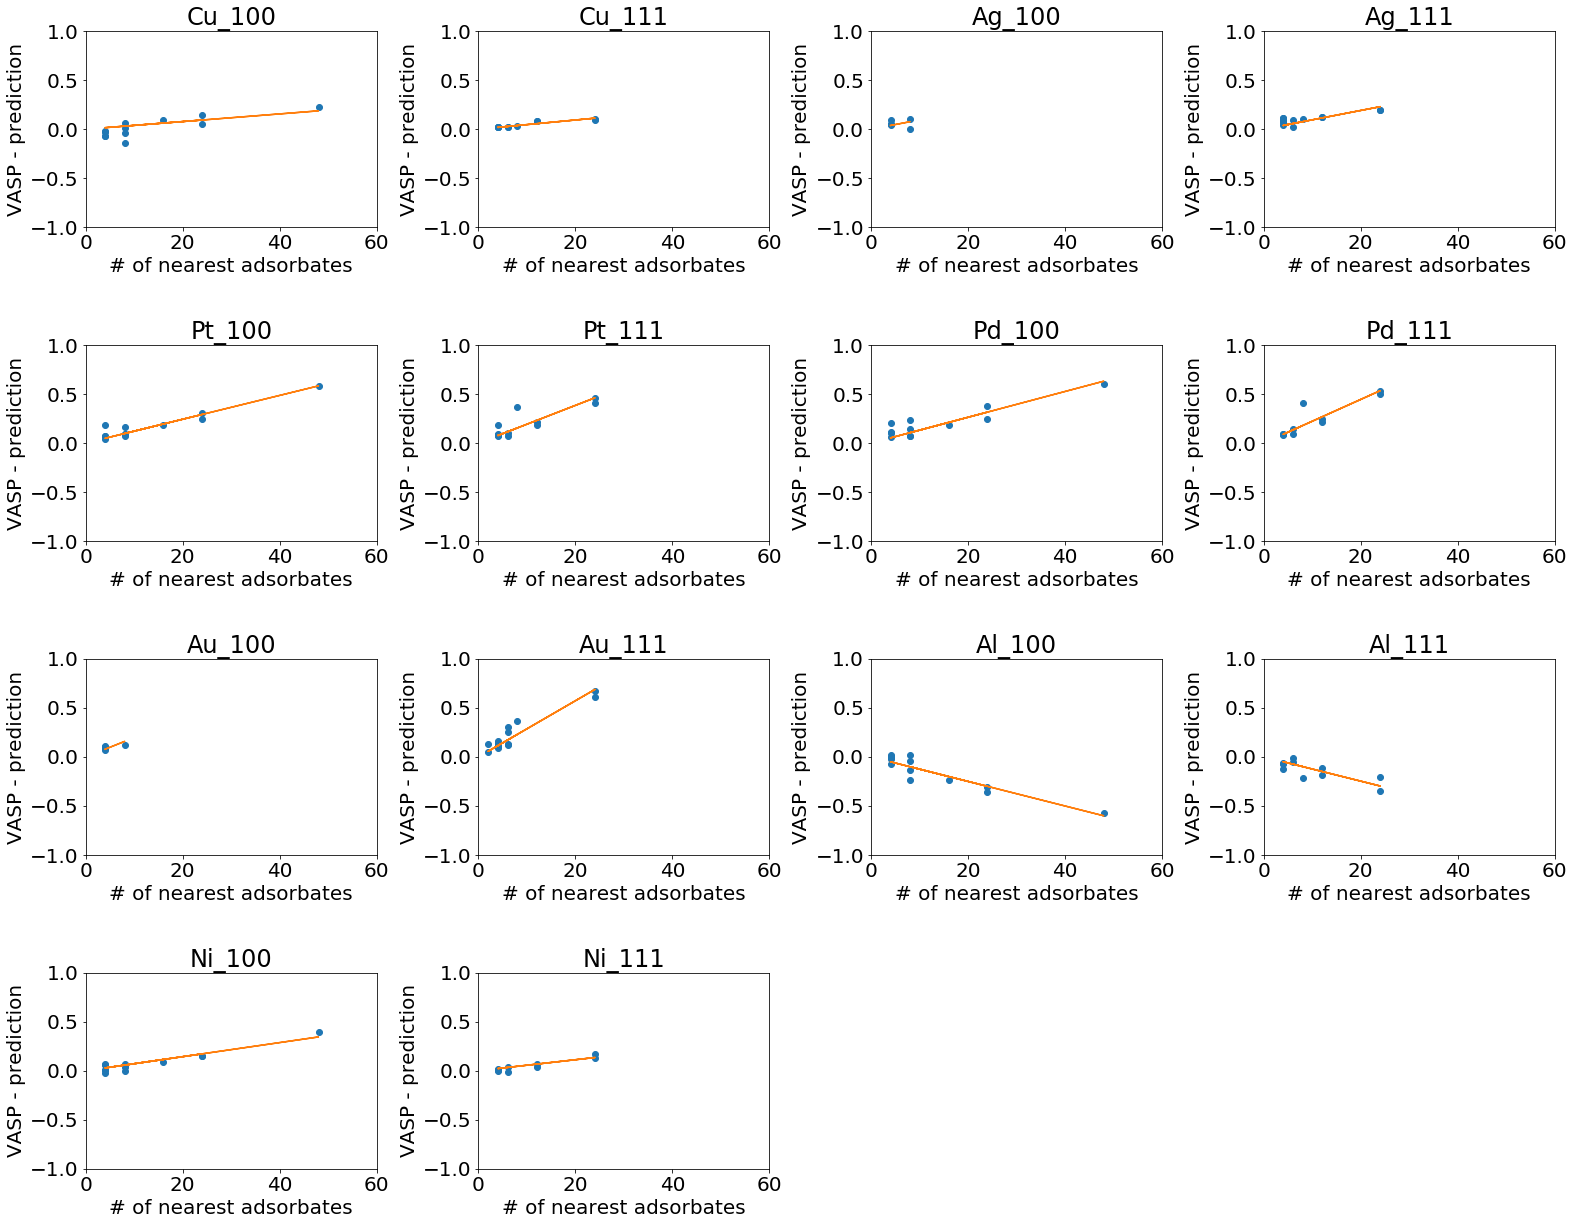

In [73]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
slopes2 = []

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    X = np.array(dfpred[i][dfpred[i]['nbdist']==2]['#nbads'])
    y = np.array(dfpred[i][dfpred[i]['nbdist']==2]['VASP - prediction'])
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)
    slopes2.append(slope)

    ax.plot(X, y, 'o')
    ax.plot(X, fitres, '-')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
#     plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

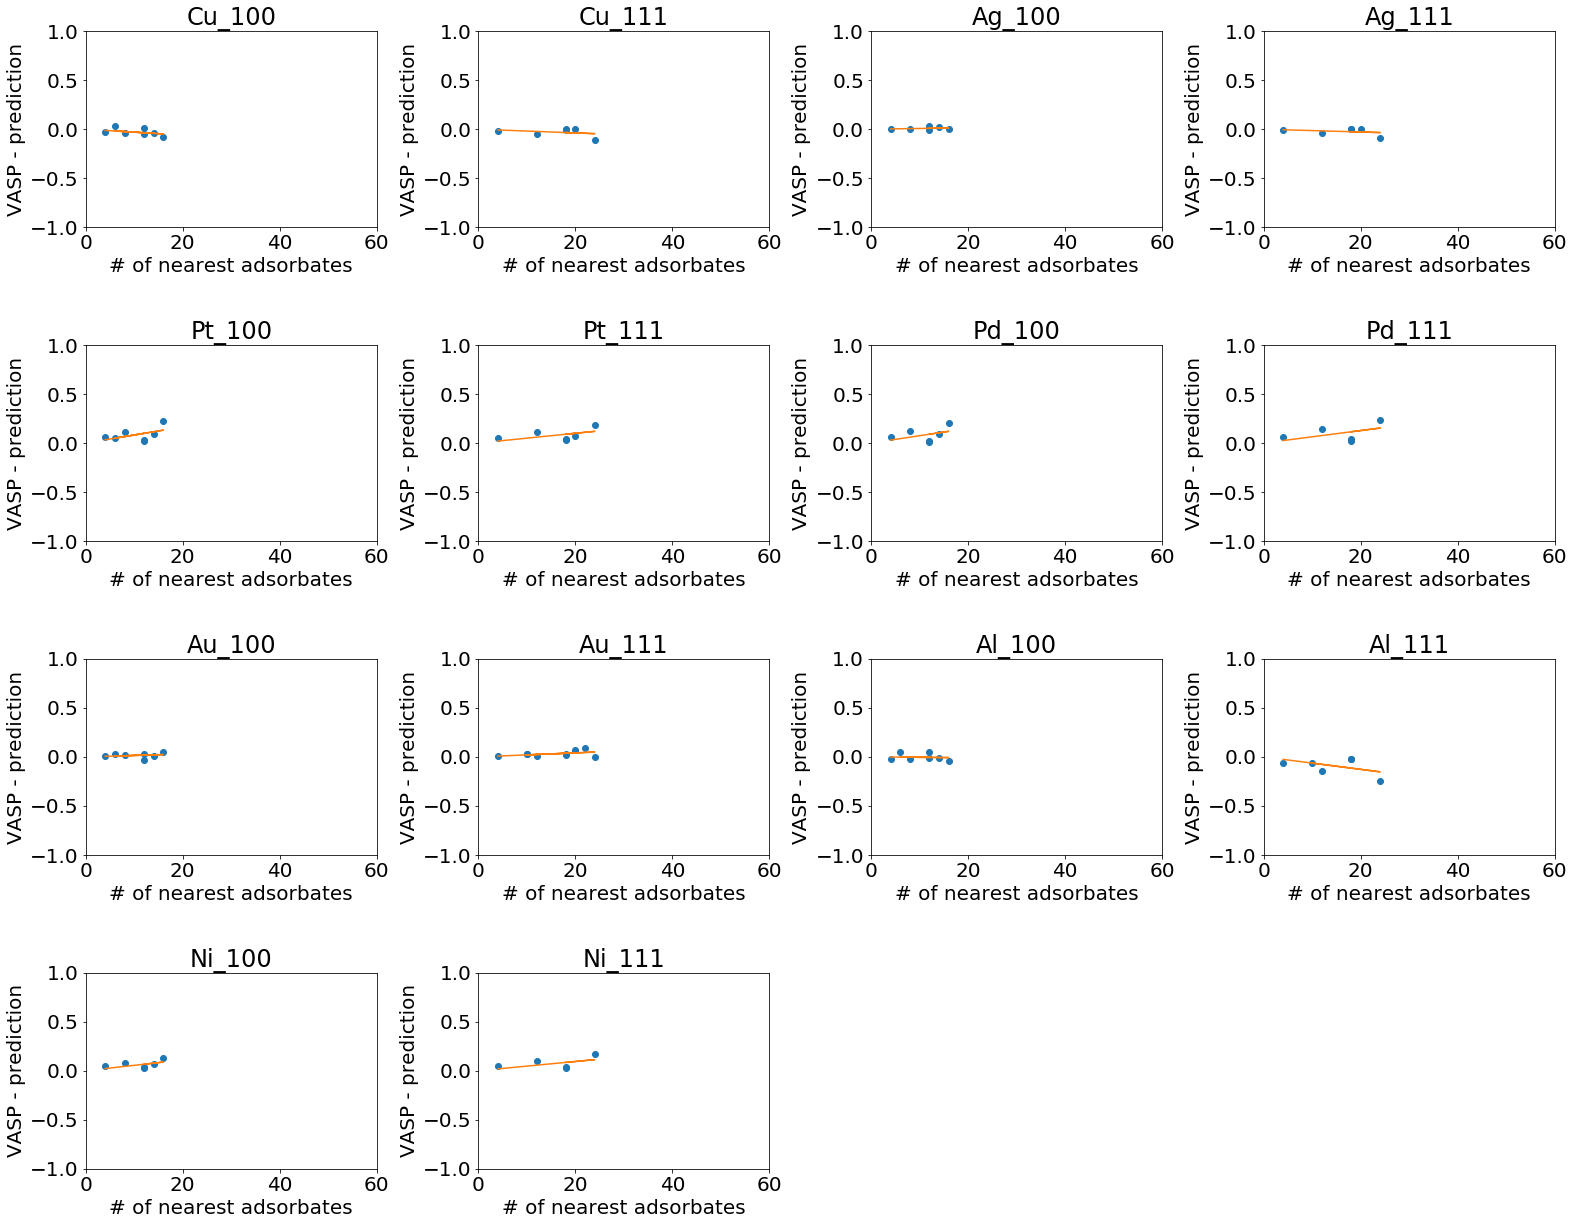

In [75]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
slopes3 = []

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    X = np.array(dfpred[i][dfpred[i]['nbdist']==3]['#nbads'])
    y = np.array(dfpred[i][dfpred[i]['nbdist']==3]['VASP - prediction'])
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)
    slopes3.append(slope)

    ax.plot(X, y, 'o')
    ax.plot(X, fitres, '-')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
#     plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [83]:
for item in slopes3:
    print(item)

[-0.00302335]
[-0.00189925]
[0.00073378]
[-0.00142921]
[0.00823093]
[0.00497808]
[0.00747731]
[0.00636418]
[0.00147808]
[0.00204164]
[-0.0004419]
[-0.00636254]
[0.00551048]
[0.00471202]
